In [4]:
!pip install krippendorff --quiet

In [5]:
from google.colab import drive
import os
import pandas as pd
import numpy as np
from statsmodels.stats.inter_rater import fleiss_kappa, aggregate_raters
import krippendorff

In [3]:
path_archivos = '/content/drive/MyDrive/PROYECTO/'
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import os
import re
import pandas as pd

# Your mapping of folder → model name
folders_dic = {
    "relationships_flant5_goal_arg":       "flant5+RoBERTa",
    "relationships_goal_and_args_keywords":"gpt+key+RoBERTa",
    "relationships_goal_and_args":         "gpt+RoBERTa",
    "relationships_goal_and_args_extract_classify_gpt":     "gpt",
    "relationships_goal_and_args_extract_classify_gpt_key": "gpt+keys",
    "relationships_goal_and_args_extract_classify_llama":   "llama",
}

# List to collect all the per-file DataFrames
dfs = []

for folder, model_name in folders_dic.items():
    for fname in os.listdir(path_archivos + folder):
        # find all numbers in the filename
        nums = re.findall(r'(\d+)', fname)
        goal_num = None
        for n in nums:
            ni = int(n)
            if 1 <= ni <= 17:
                goal_num = ni
                break
        if goal_num is None:
            continue

        path = path_archivos + folder + '/'+ fname
        #print(path)
        df = pd.read_csv(path)
        df["model"] = model_name
        df["goal"]  = goal_num
        dfs.append(df)


all_data = pd.concat(dfs, ignore_index=True)
all_data = all_data[
    ["model", "goal", "id_argumento1", "id_argumento2", "relacion", "label"]
]

print(f"Loaded {len(dfs)} files into a single DataFrame with shape {all_data.shape}")
all_data.head()


Loaded 102 files into a single DataFrame with shape (1095, 6)


,model,goal,id_argumento1,id_argumento2,relacion,label
0,flant5+RoBERTa,17,Strengthen the means of implementation and rev...,Developing countries face a $4 trillion annual...,Inference,Conflict
1,flant5+RoBERTa,17,Strengthen the means of implementation and rev...,External debt stock levels have remained unpre...,Inference,Conflict
2,flant5+RoBERTa,17,Strengthen the means of implementation and rev...,Approximately 67 per cent of the world’s popul...,Inference,Inference
3,flant5+RoBERTa,17,Strengthen the means of implementation and rev...,The COVID-19 pandemic highlighted the importan...,Inference,Inference
4,flant5+RoBERTa,17,Strengthen the means of implementation and rev...,Strengthened global partnerships and enhanced ...,Inference,Inference


In [29]:
pd.set_option('display.max_rows', 320)
pd.set_option('display.max_colwidth', 255)

unique_counts = (
    all_data
    .groupby(['goal', 'id_argumento1'])['id_argumento2']
    .nunique()
    .reset_index(name='argumentos por goal')
)

unique_counts.style.hide(axis='index')

goal,id_argumento1,argumentos por goal
1,End poverty in all its forms everywhere,49
2,"End hunger, achieve food security and improved nutrition and promote sustainable agriculture",53
3,Ensure healthy lives and promote well-being for all at all ages,131
4,Ensure inclusive and equitable quality education,40
5,Achieve gender equality and empower all women and girls,47
6,Ensure availability and sustainable management of water and sanitation for all,64
7,"Ensure access to affordable, reliable, sustainable and modern energy for all",38
8,"Promote sustained, inclusive and sustainable economic growth, full and productive employment and decent work for all",58
9,"Build resilient infrastructure, promote inclusive and sustainable industrialization and foster innovation",46
10,Reduce inequality within and among countries,43


In [45]:
print('Eliminando argumentos irrelevantes:')
unique_counts = (
    all_data.dropna(subset=['label'])
    .groupby(['goal', 'id_argumento1'])['id_argumento2']
    .nunique()
    .reset_index(name='argumentos por goal')
)

unique_counts.style.hide(axis='index')

Eliminando argumentos irrelevantes:


goal,id_argumento1,argumentos por goal
1,End poverty in all its forms everywhere,40
2,"End hunger, achieve food security and improved nutrition and promote sustainable agriculture",43
3,Ensure healthy lives and promote well-being for all at all ages,74
4,Ensure inclusive and equitable quality education,32
5,Achieve gender equality and empower all women and girls,42
6,Ensure availability and sustainable management of water and sanitation for all,40
7,"Ensure access to affordable, reliable, sustainable and modern energy for all",29
8,"Promote sustained, inclusive and sustainable economic growth, full and productive employment and decent work for all",39
9,"Build resilient infrastructure, promote inclusive and sustainable industrialization and foster innovation",29
10,Reduce inequality within and among countries,38


## Metricas por goal y por modelo sobre los argumentos que detecta cada modelo

In [66]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
df = all_data.copy()
df['label'] = all_data['label'].fillna('nulo')

def compute_metrics(df):
    y_true = df['label']
    y_pred = df['relacion']
    return pd.Series({
        'accuracy':  round(accuracy_score(y_true, y_pred)*100,2),
        'precision': round(precision_score(y_true, y_pred, average='macro', zero_division=0)*100,2),
        'recall':    round(recall_score(y_true, y_pred, average='macro', zero_division=0)*100,2),
        'f1':        round(f1_score(y_true, y_pred, average='macro', zero_division=0)*100,2),
        'argumentos': len(y_pred),
        'argumentos mal detectados': len(df[df['label']=='nulo'])
    })

# group by model & goal, apply the metric function, reset index to get a clean table
metrics_table = (
    df
    .groupby(['goal', 'model'])
    .apply(compute_metrics)
    .reset_index()
)

for goal in metrics_table['goal'].unique():
  metrics_table_filtrada = metrics_table[metrics_table['goal'] == goal]
  model_order = ['flant5+RoBERTa', 'gpt+key+RoBERTa', 'gpt+RoBERTa', 'llama', 'gpt', 'gpt+keys']

  # Convert model column to a categorical with the specified order
  metrics_table_filtrada['model'] = pd.Categorical(
      metrics_table_filtrada['model'],
      categories=model_order,
      ordered=True
  )

  # Sort by model (in your custom order), then by goal
  metrics_table_filtrada = metrics_table_filtrada.sort_values(['model', 'goal'])

  # Display formatted table
  display(
      metrics_table_filtrada
      .style
      .hide(axis='index')
      .format(precision=2)
      .format(subset=['argumentos', 'argumentos mal detectados'], precision=0)
  )


<ipython-input-66-def31e1552f2>:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(compute_metrics)
<ipython-input-66-def31e1552f2>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_table_filtrada['model'] = pd.Categorical(


goal,model,accuracy,precision,recall,f1,argumentos,argumentos mal detectados
1,flant5+RoBERTa,11.11,5.56,50.00,10.00,9,0
1,gpt+key+RoBERTa,28.00,20.98,20.83,16.36,25,5
1,gpt+RoBERTa,0.00,0.00,0.00,0.00,3,0
1,llama,16.67,11.11,11.11,11.11,6,3
1,gpt,75.00,50.00,66.67,57.14,8,2
1,gpt+keys,100.00,100.00,100.00,100.00,6,0


<ipython-input-66-def31e1552f2>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_table_filtrada['model'] = pd.Categorical(


goal,model,accuracy,precision,recall,f1,argumentos,argumentos mal detectados
2,flant5+RoBERTa,55.56,18.52,33.33,23.81,9,0
2,gpt+key+RoBERTa,13.33,8.82,8.26,7.69,30,7
2,gpt+RoBERTa,40.00,20.00,50.00,28.57,5,0
2,llama,40.00,20.00,50.00,28.57,5,3
2,gpt,100.00,100.00,100.00,100.00,6,0
2,gpt+keys,100.00,100.00,100.00,100.00,6,0


<ipython-input-66-def31e1552f2>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_table_filtrada['model'] = pd.Categorical(


goal,model,accuracy,precision,recall,f1,argumentos,argumentos mal detectados
3,flant5+RoBERTa,26.32,8.77,33.33,13.89,19,0
3,gpt+key+RoBERTa,19.05,10.60,22.00,11.39,105,55
3,gpt+RoBERTa,23.08,39.39,36.36,15.81,13,0
3,llama,0.00,0.00,0.00,0.00,3,2
3,gpt,62.50,41.67,58.33,47.22,8,2
3,gpt+keys,75.00,50.00,66.67,57.14,8,2


<ipython-input-66-def31e1552f2>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_table_filtrada['model'] = pd.Categorical(


goal,model,accuracy,precision,recall,f1,argumentos,argumentos mal detectados
4,flant5+RoBERTa,33.33,16.67,50.00,25.00,9,0
4,gpt+key+RoBERTa,33.33,20.95,28.33,24.07,12,3
4,gpt+RoBERTa,0.00,0.00,0.00,0.00,2,0
4,llama,80.00,83.33,83.33,80.00,5,0
4,gpt,62.50,41.67,58.33,47.22,8,2
4,gpt+keys,62.50,41.67,66.67,46.67,8,3


<ipython-input-66-def31e1552f2>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_table_filtrada['model'] = pd.Categorical(


goal,model,accuracy,precision,recall,f1,argumentos,argumentos mal detectados
5,flant5+RoBERTa,12.50,6.25,50.00,11.11,16,0
5,gpt+key+RoBERTa,35.71,32.14,32.50,22.65,14,2
5,gpt+RoBERTa,66.67,50.00,53.33,47.22,6,0
5,llama,40.00,33.33,22.22,26.67,5,2
5,gpt,83.33,83.33,87.50,82.86,6,0
5,gpt+keys,83.33,55.56,66.67,60.00,6,1


<ipython-input-66-def31e1552f2>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_table_filtrada['model'] = pd.Categorical(


goal,model,accuracy,precision,recall,f1,argumentos,argumentos mal detectados
6,flant5+RoBERTa,45.45,15.15,33.33,20.83,11,0
6,gpt+key+RoBERTa,17.78,8.20,16.24,10.90,45,23
6,gpt+RoBERTa,33.33,13.33,22.22,16.67,6,0
6,llama,66.67,44.44,55.56,48.89,6,1
6,gpt,100.00,100.00,100.00,100.00,6,0
6,gpt+keys,83.33,55.56,66.67,60.00,6,1


<ipython-input-66-def31e1552f2>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_table_filtrada['model'] = pd.Categorical(


goal,model,accuracy,precision,recall,f1,argumentos,argumentos mal detectados
7,flant5+RoBERTa,28.57,9.52,33.33,14.81,7,0
7,gpt+key+RoBERTa,23.08,18.06,16.25,15.48,13,4
7,gpt+RoBERTa,33.33,13.33,22.22,16.67,6,0
7,llama,42.86,30.00,50.00,35.71,7,3
7,gpt,90.00,60.00,66.67,62.96,10,1
7,gpt+keys,83.33,55.56,66.67,60.00,6,1


<ipython-input-66-def31e1552f2>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_table_filtrada['model'] = pd.Categorical(


goal,model,accuracy,precision,recall,f1,argumentos,argumentos mal detectados
8,flant5+RoBERTa,0.00,0.00,0.00,0.00,10,0
8,gpt+key+RoBERTa,15.38,8.60,12.35,9.35,39,17
8,gpt+RoBERTa,50.00,33.33,16.67,22.22,6,0
8,llama,60.00,50.00,50.00,44.44,5,1
8,gpt,50.00,33.33,55.56,38.89,6,2
8,gpt+keys,100.00,100.00,100.00,100.00,5,0


<ipython-input-66-def31e1552f2>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_table_filtrada['model'] = pd.Categorical(


goal,model,accuracy,precision,recall,f1,argumentos,argumentos mal detectados
9,flant5+RoBERTa,50.00,16.67,33.33,22.22,8,0
9,gpt+key+RoBERTa,12.50,11.67,20.37,10.68,24,11
9,gpt+RoBERTa,20.00,12.50,25.00,16.67,5,0
9,llama,42.86,30.00,38.89,33.33,7,2
9,gpt,71.43,47.22,66.67,55.24,7,2
9,gpt+keys,50.00,33.33,55.56,38.89,6,2


<ipython-input-66-def31e1552f2>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_table_filtrada['model'] = pd.Categorical(


goal,model,accuracy,precision,recall,f1,argumentos,argumentos mal detectados
10,flant5+RoBERTa,50.00,16.67,33.33,22.22,12,0
10,gpt+key+RoBERTa,13.33,12.50,5.00,7.14,15,4
10,gpt+RoBERTa,0.00,0.00,0.00,0.00,3,0
10,llama,80.00,50.00,66.67,55.56,5,1
10,gpt,50.00,50.00,50.00,48.57,6,0
10,gpt+keys,100.00,100.00,100.00,100.00,5,0


<ipython-input-66-def31e1552f2>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_table_filtrada['model'] = pd.Categorical(


goal,model,accuracy,precision,recall,f1,argumentos,argumentos mal detectados
11,flant5+RoBERTa,26.67,8.89,33.33,14.04,15,0
11,gpt+key+RoBERTa,23.53,32.50,54.55,20.57,17,4
11,gpt+RoBERTa,57.14,52.22,72.22,54.17,14,0
11,llama,33.33,22.22,13.33,16.67,6,1
11,gpt,87.50,87.50,90.00,87.30,8,0
11,gpt+keys,66.67,44.44,58.33,45.24,6,1


<ipython-input-66-def31e1552f2>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_table_filtrada['model'] = pd.Categorical(


goal,model,accuracy,precision,recall,f1,argumentos,argumentos mal detectados
12,flant5+RoBERTa,35.71,17.86,50.00,26.32,14,0
12,gpt+key+RoBERTa,28.57,17.36,30.00,21.87,28,13
12,gpt+RoBERTa,28.57,13.33,16.67,14.81,7,0
12,llama,0.00,0.00,0.00,0.00,2,1
12,gpt,62.50,41.67,66.67,46.67,8,3
12,gpt+keys,50.00,33.33,33.33,33.33,6,3


<ipython-input-66-def31e1552f2>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_table_filtrada['model'] = pd.Categorical(


goal,model,accuracy,precision,recall,f1,argumentos,argumentos mal detectados
13,flant5+RoBERTa,42.86,14.29,33.33,20.00,14,0
13,gpt+key+RoBERTa,20.00,11.28,15.71,12.47,25,11
13,gpt+RoBERTa,44.44,47.62,33.33,31.52,9,0
13,llama,57.14,54.17,55.00,53.33,7,0
13,gpt,100.00,100.00,100.00,100.00,5,0
13,gpt+keys,100.00,100.00,100.00,100.00,4,0


<ipython-input-66-def31e1552f2>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_table_filtrada['model'] = pd.Categorical(


goal,model,accuracy,precision,recall,f1,argumentos,argumentos mal detectados
14,flant5+RoBERTa,30.77,10.26,33.33,15.69,13,2
14,gpt+key+RoBERTa,23.53,6.67,20.00,10.00,17,2
14,gpt+RoBERTa,25.00,10.00,10.00,10.00,8,1
14,llama,100.00,100.00,100.00,100.00,5,0
14,gpt,85.71,55.56,66.67,60.00,7,1
14,gpt+keys,100.00,100.00,100.00,100.00,6,0


<ipython-input-66-def31e1552f2>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_table_filtrada['model'] = pd.Categorical(


goal,model,accuracy,precision,recall,f1,argumentos,argumentos mal detectados
15,flant5+RoBERTa,27.27,9.09,33.33,14.29,11,0
15,gpt+key+RoBERTa,28.57,12.50,25.00,16.07,21,8
15,gpt+RoBERTa,40.00,13.33,33.33,19.05,5,0
15,llama,33.33,33.33,20.00,25.00,6,0
15,gpt,42.86,30.56,46.67,30.00,7,1
15,gpt+keys,100.00,100.00,100.00,100.00,5,0


<ipython-input-66-def31e1552f2>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_table_filtrada['model'] = pd.Categorical(


goal,model,accuracy,precision,recall,f1,argumentos,argumentos mal detectados
16,flant5+RoBERTa,11.11,3.70,33.33,6.67,9,0
16,gpt+key+RoBERTa,20.00,25.00,42.22,17.83,30,13
16,gpt+RoBERTa,66.67,66.67,80.00,62.50,6,0
16,llama,75.00,75.00,83.33,73.33,4,0
16,gpt+keys,100.00,100.00,100.00,100.00,4,0


<ipython-input-66-def31e1552f2>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_table_filtrada['model'] = pd.Categorical(


goal,model,accuracy,precision,recall,f1,argumentos,argumentos mal detectados
17,flant5+RoBERTa,60.00,30.00,50.00,37.50,10,0
17,gpt+key+RoBERTa,16.67,5.68,15.62,8.33,30,13
17,gpt+RoBERTa,33.33,11.11,33.33,16.67,6,2
17,llama,100.00,100.00,100.00,100.00,2,0
17,gpt,100.00,100.00,100.00,100.00,10,0
17,gpt+keys,100.00,100.00,100.00,100.00,4,0


## Metricas por modelo sobre los arg. detectados por cada modelo

In [67]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
df = all_data.copy()
df['label'] = all_data['label'].fillna('nulo')

def compute_metrics(df):
    y_true = df['label']
    y_pred = df['relacion']
    return pd.Series({
        'accuracy':  round(accuracy_score(y_true, y_pred)*100,2),
        'precision': round(precision_score(y_true, y_pred, average='macro', zero_division=0)*100,2),
        'recall':    round(recall_score(y_true, y_pred, average='macro', zero_division=0)*100,2),
        'f1':        round(f1_score(y_true, y_pred, average='macro', zero_division=0)*100,2),
        'argumentos': len(y_pred),
        'argumentos mal detectados': len(df[df['label']=='nulo'])
    })

# group by model & goal, apply the metric function, reset index to get a clean table
metrics_table = (
    df
    .groupby(['model'])
    .apply(compute_metrics)
    .reset_index()
)

model_order = ['flant5+RoBERTa', 'gpt+key+RoBERTa', 'gpt+RoBERTa', 'llama', 'gpt', 'gpt+keys']


metrics_table['model'] = pd.Categorical(
    metrics_table['model'],
    categories=model_order,
    ordered=True
)

# Sort by model (in your custom order), then by goal
metrics_table = metrics_table.sort_values(['model'])

# Display formatted table
display(
    metrics_table
    .style
    .hide(axis='index')
    .format(precision=2)
    .format(subset=['argumentos', 'argumentos mal detectados'], precision=0)
)



<ipython-input-67-9697765fd0fb>:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(compute_metrics)


model,accuracy,precision,recall,f1,argumentos,argumentos mal detectados
flant5+RoBERTa,31.63,7.91,25.00,12.02,196,2
gpt+key+RoBERTa,20.41,10.27,18.21,11.77,490,195
gpt+RoBERTa,37.27,21.25,23.38,21.48,110,3
llama,51.16,35.67,47.22,38.60,86,20
gpt,76.72,51.17,59.87,54.99,116,16
gpt+keys,83.51,55.36,65.31,59.67,97,14


## Metricas sobre todos los argumentos detectados por goal


In [72]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

df_labeled = all_data.dropna(subset=['label'])

true_labels = (
    df_labeled
    .groupby(['goal','id_argumento2'])['label']
    .first()
    .reset_index(name='true_label')
)

models = df_labeled['model'].unique()

records = []
for model in models:
    # 3a) grab only the model's own predictions
    preds = (
        df_labeled[df_labeled['model']==model]
        .loc[:, ['goal','id_argumento2','relacion']]
        .drop_duplicates(['goal','id_argumento2'])
    )
    # 3b) merge with the full universe; fill missing with "nulo"
    merged = true_labels.merge(
        preds,
        on=['goal','id_argumento2'],
        how='left'
    )
    merged['predicted'] = merged['relacion'].fillna('nulo')

    # 4) compute metrics for each goal
    for goal, sub in merged.groupby('goal'):
        y_true = sub['true_label']
        y_pred = sub['predicted']

        records.append({
            'goal':      goal,
            'model':     model,
            'accuracy':  accuracy_score(y_true, y_pred)*100,
            'precision': precision_score(y_true, y_pred, average='macro', zero_division=0)*100,
            'recall':    recall_score(y_true, y_pred, average='macro', zero_division=0)*100,
            'F1':        f1_score(y_true, y_pred, average='macro', zero_division=0)*100,
            'argumentos': len(y_pred),
        })


metrics_filled = pd.DataFrame.from_records(records)
order = ['flant5+RoBERTa','gpt+key+RoBERTa','gpt+RoBERTa','llama','gpt','gpt+keys']
metrics_filled['model'] = pd.Categorical(metrics_filled['model'], categories=order, ordered=True)
metrics_filled = metrics_filled.sort_values(['model','goal']).reset_index(drop=True)

for goal in metrics_filled['goal'].unique():
  metrics_table_filtrada = metrics_filled[metrics_filled['goal'] == goal]
  model_order = ['flant5+RoBERTa', 'gpt+key+RoBERTa', 'gpt+RoBERTa', 'llama', 'gpt', 'gpt+keys']

  # Convert model column to a categorical with the specified order
  metrics_table_filtrada['model'] = pd.Categorical(
      metrics_table_filtrada['model'],
      categories=model_order,
      ordered=True
  )

  # Sort by model (in your custom order), then by goal
  metrics_table_filtrada = metrics_table_filtrada.sort_values(['model', 'goal'])

  # Display formatted table
  display(
      metrics_table_filtrada
      .style
      .hide(axis='index')
      .format(precision=2)
      .format(subset=['argumentos'], precision=0)
  )


<ipython-input-72-557052abd2d1>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_table_filtrada['model'] = pd.Categorical(


goal,model,accuracy,precision,recall,F1,argumentos
1,flant5+RoBERTa,2.50,3.70,3.03,3.33,40
1,gpt+key+RoBERTa,17.50,22.40,8.86,11.49,40
1,gpt+RoBERTa,2.50,16.67,1.15,2.15,40
1,llama,2.50,33.33,1.15,2.22,40
1,gpt,15.00,66.67,12.54,20.54,40
1,gpt+keys,15.00,66.67,12.54,20.54,40


<ipython-input-72-557052abd2d1>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_table_filtrada['model'] = pd.Categorical(


goal,model,accuracy,precision,recall,F1,argumentos
2,flant5+RoBERTa,11.63,13.89,6.94,9.26,43
2,gpt+key+RoBERTa,9.30,10.26,4.51,6.16,43
2,gpt+RoBERTa,4.65,10.00,2.08,3.45,43
2,llama,4.65,25.00,2.78,5.00,43
2,gpt,13.95,50.00,7.29,12.70,43
2,gpt+keys,13.95,50.00,7.29,12.70,43


<ipython-input-72-557052abd2d1>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_table_filtrada['model'] = pd.Categorical(


goal,model,accuracy,precision,recall,F1,argumentos
3,flant5+RoBERTa,6.76,6.58,4.46,5.32,74
3,gpt+key+RoBERTa,27.03,22.76,16.51,15.71,74
3,gpt+RoBERTa,4.05,29.55,2.34,3.65,74
3,llama,0.00,0.00,0.00,0.00,74
3,gpt,6.76,41.67,3.45,6.35,74
3,gpt+keys,8.11,50.00,4.35,7.96,74


<ipython-input-72-557052abd2d1>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_table_filtrada['model'] = pd.Categorical(


goal,model,accuracy,precision,recall,F1,argumentos
4,flant5+RoBERTa,9.38,11.11,8.33,9.52,32
4,gpt+key+RoBERTa,12.50,27.78,7.78,12.14,32
4,gpt+RoBERTa,0.00,0.00,0.00,0.00,32
4,llama,12.50,55.56,8.89,14.95,32
4,gpt,15.62,55.56,10.56,17.58,32
4,gpt+keys,15.62,66.67,9.44,16.24,32


<ipython-input-72-557052abd2d1>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_table_filtrada['model'] = pd.Categorical(


goal,model,accuracy,precision,recall,F1,argumentos
5,flant5+RoBERTa,4.76,4.17,8.33,5.56,42
5,gpt+key+RoBERTa,11.90,33.33,8.46,11.20,42
5,gpt+RoBERTa,9.52,37.50,5.33,9.05,42
5,llama,4.76,33.33,1.96,3.70,42
5,gpt,11.90,55.56,11.27,17.53,42
5,gpt+keys,11.90,66.67,11.27,18.74,42


<ipython-input-72-557052abd2d1>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_table_filtrada['model'] = pd.Categorical(


goal,model,accuracy,precision,recall,F1,argumentos
6,flant5+RoBERTa,12.50,11.36,6.94,8.62,40
6,gpt+key+RoBERTa,20.00,16.67,9.72,11.90,40
6,gpt+RoBERTa,5.00,10.00,2.38,3.85,40
6,llama,10.00,41.67,5.16,9.11,40
6,gpt,15.00,50.00,7.74,13.39,40
6,gpt+keys,12.50,50.00,6.55,11.49,40


<ipython-input-72-557052abd2d1>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_table_filtrada['model'] = pd.Categorical(


goal,model,accuracy,precision,recall,F1,argumentos
7,flant5+RoBERTa,6.90,7.14,3.57,4.76,29
7,gpt+key+RoBERTa,6.90,17.50,3.57,5.76,29
7,gpt+RoBERTa,6.90,10.00,3.57,5.26,29
7,llama,10.34,41.67,5.36,9.22,29
7,gpt,31.03,50.00,16.07,24.27,29
7,gpt+keys,17.24,50.00,8.93,15.07,29


<ipython-input-72-557052abd2d1>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_table_filtrada['model'] = pd.Categorical(


goal,model,accuracy,precision,recall,F1,argumentos
8,flant5+RoBERTa,0.00,0.00,0.00,0.00,39
8,gpt+key+RoBERTa,15.38,16.16,7.29,9.04,39
8,gpt+RoBERTa,7.69,25.00,2.50,4.55,39
8,llama,7.69,41.67,7.08,10.70,39
8,gpt,7.69,37.50,4.79,8.12,39
8,gpt+keys,12.82,50.00,8.75,14.55,39


<ipython-input-72-557052abd2d1>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_table_filtrada['model'] = pd.Categorical(


goal,model,accuracy,precision,recall,F1,argumentos
9,flant5+RoBERTa,13.79,12.50,9.09,10.53,29
9,gpt+key+RoBERTa,10.34,13.33,6.02,7.26,29
9,gpt+RoBERTa,3.45,6.25,2.27,3.33,29
9,llama,10.34,29.17,6.02,9.77,29
9,gpt,17.24,50.00,9.76,15.98,29
9,gpt+keys,10.34,37.50,5.21,9.11,29


<ipython-input-72-557052abd2d1>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_table_filtrada['model'] = pd.Categorical(


goal,model,accuracy,precision,recall,F1,argumentos
10,flant5+RoBERTa,15.79,12.50,10.71,11.54,38
10,gpt+key+RoBERTa,5.26,16.67,2.17,3.85,38
10,gpt+RoBERTa,2.63,25.00,1.09,2.08,38
10,llama,10.53,50.00,6.44,10.91,38
10,gpt,7.89,25.00,3.96,6.79,38
10,gpt+keys,13.16,50.00,6.83,12.02,38


<ipython-input-72-557052abd2d1>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_table_filtrada['model'] = pd.Categorical(


goal,model,accuracy,precision,recall,F1,argumentos
11,flant5+RoBERTa,9.09,6.67,11.11,8.33,44
11,gpt+key+RoBERTa,9.09,34.82,16.79,14.32,44
11,gpt+RoBERTa,18.18,39.17,21.84,23.55,44
11,llama,2.27,25.00,0.76,1.47,44
11,gpt,15.91,43.75,11.36,16.94,44
11,gpt+keys,9.09,37.50,5.05,8.71,44


<ipython-input-72-557052abd2d1>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_table_filtrada['model'] = pd.Categorical(


goal,model,accuracy,precision,recall,F1,argumentos
12,flant5+RoBERTa,13.51,11.90,11.90,11.90,37
12,gpt+key+RoBERTa,21.62,29.55,12.53,17.43,37
12,gpt+RoBERTa,5.41,10.00,2.17,3.57,37
12,llama,0.00,0.00,0.00,0.00,37
12,gpt,13.51,66.67,10.97,17.59,37
12,gpt+keys,8.11,33.33,4.35,7.69,37


<ipython-input-72-557052abd2d1>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_table_filtrada['model'] = pd.Categorical(


goal,model,accuracy,precision,recall,F1,argumentos
13,flant5+RoBERTa,17.65,10.71,12.50,11.54,34
13,gpt+key+RoBERTa,17.65,18.00,7.14,10.22,34
13,gpt+RoBERTa,11.76,35.71,5.65,9.20,34
13,llama,11.76,27.08,5.65,9.33,34
13,gpt,14.71,50.00,7.74,13.39,34
13,gpt+keys,11.76,50.00,6.55,11.49,34


<ipython-input-72-557052abd2d1>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_table_filtrada['model'] = pd.Categorical(


goal,model,accuracy,precision,recall,F1,argumentos
14,flant5+RoBERTa,11.43,9.09,5.56,6.90,35
14,gpt+key+RoBERTa,8.57,5.36,4.69,5.00,35
14,gpt+RoBERTa,2.86,6.25,1.56,2.50,35
14,llama,14.29,50.00,7.29,12.70,35
14,gpt,17.14,50.00,8.68,14.65,35
14,gpt+keys,17.14,50.00,8.85,15.04,35


<ipython-input-72-557052abd2d1>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_table_filtrada['model'] = pd.Categorical(


goal,model,accuracy,precision,recall,F1,argumentos
15,flant5+RoBERTa,8.33,6.82,7.50,7.14,36
15,gpt+key+RoBERTa,16.67,23.86,7.50,11.11,36
15,gpt+RoBERTa,5.56,10.00,2.00,3.33,36
15,llama,5.56,16.67,2.00,3.57,36
15,gpt,8.33,31.25,4.50,7.28,36
15,gpt+keys,13.89,50.00,6.50,11.44,36


<ipython-input-72-557052abd2d1>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_table_filtrada['model'] = pd.Categorical(


goal,model,accuracy,precision,recall,F1,argumentos
16,flant5+RoBERTa,3.23,2.78,4.17,3.33,31
16,gpt+key+RoBERTa,19.35,28.85,12.50,12.41,31
16,gpt+RoBERTa,9.68,25.00,3.12,5.56,31
16,llama,9.68,37.50,6.25,10.10,31
16,gpt,0.00,0.00,0.00,0.00,31
16,gpt+keys,12.90,50.00,10.42,16.35,31


<ipython-input-72-557052abd2d1>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_table_filtrada['model'] = pd.Categorical(


goal,model,accuracy,precision,recall,F1,argumentos
17,flant5+RoBERTa,15.38,20.00,9.52,12.90,39
17,gpt+key+RoBERTa,12.82,11.36,5.95,7.81,39
17,gpt+RoBERTa,5.13,16.67,3.17,5.33,39
17,llama,5.13,33.33,3.17,5.80,39
17,gpt,25.64,66.67,17.20,27.31,39
17,gpt+keys,10.26,66.67,6.88,12.46,39


## Metricas sobre todos los argumentos detectados por modelo

In [78]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 1) Drop unlabeled rows
df_labeled = all_data.dropna(subset=['label'])

# 2) Build the universe of every (goal, id_argumento2) → true_label
true_labels = (
    df_labeled
    .groupby(['goal','id_argumento2'])['label']
    .first()
    .reset_index(name='true_label')
)

# 3) For each model, merge in its predictions (filling missing with "nulo") and compute metrics
models = df_labeled['model'].unique()
records = []

for model in models:
    # pull this model’s own predictions, one per (goal, id_argumento2)
    preds = (
        df_labeled[df_labeled['model']==model]
        .drop_duplicates(['goal','id_argumento2'])
        .loc[:, ['goal','id_argumento2','relacion']]
    )
    merged = true_labels.merge(preds, on=['goal','id_argumento2'], how='left')
    merged['predicted'] = merged['relacion'].fillna('nulo')

    # compute overall metrics (across all goals at once)
    y_true = merged['true_label']
    y_pred = merged['predicted']

    records.append({
        'model':     model,
        'accuracy':  accuracy_score(y_true, y_pred)*100,
        'precision': precision_score(y_true, y_pred, average='macro', zero_division=0)*100,
        'recall':    recall_score(y_true, y_pred, average='macro', zero_division=0)*100,
        'f1':        f1_score(y_true, y_pred, average='macro', zero_division=0)*100,
        'argumentos': len(y_pred),
    })

metrics_by_model = pd.DataFrame.from_records(records)

# 4) (Optional) sort in your desired model order
order = ['flant5+RoBERTa','gpt+key+RoBERTa','gpt+RoBERTa','llama','gpt','gpt+keys']
metrics_by_model['model'] = pd.Categorical(metrics_by_model['model'], categories=order, ordered=True)
metrics_by_model = metrics_by_model.sort_values('model').reset_index(drop=True)

metrics_by_model.style.hide(axis='index').format(precision=2)


model,accuracy,precision,recall,f1,argumentos
flant5+RoBERTa,9.37,7.99,6.68,7.28,662
gpt+key+RoBERTa,14.95,15.86,7.73,9.61,662
gpt+RoBERTa,6.19,21.58,4.75,6.80,662
llama,6.50,35.29,3.63,6.41,662
gpt,13.44,44.83,7.44,12.55,662
gpt+keys,12.24,48.61,6.48,11.41,662


In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
df = all_data.copy()
df['label'] = all_data['label'].fillna('nulo')

def compute_metrics(df):
    y_true = df['label']
    y_pred = df['relacion']
    return pd.Series({
        'accuracy':  round(accuracy_score(y_true, y_pred)*100,2),
        'precision': round(precision_score(y_true, y_pred, average='macro', zero_division=0)*100,2),
        'recall':    round(recall_score(y_true, y_pred, average='macro', zero_division=0)*100,2),
        'f1':        round(f1_score(y_true, y_pred, average='macro', zero_division=0)*100,2),
        'argumentos': len(y_pred),
        'argumentos mal detectados': len(df[df['label']=='nulo'])
    })

# group by model & goal, apply the metric function, reset index to get a clean table
metrics_table = (
    df
    .groupby(['goal', 'model'])
    .apply(compute_metrics)
    .reset_index()
)

for goal in df['goal'].unique():
  df = df[df['goal'] == goal]



  metrics_table_filtrada = metrics_table[metrics_table['goal'] == goal]
  model_order = ['flant5+RoBERTa', 'gpt+key+RoBERTa', 'gpt+RoBERTa', 'llama', 'gpt', 'gpt+keys']

  # Convert model column to a categorical with the specified order
  metrics_table_filtrada['model'] = pd.Categorical(
      metrics_table_filtrada['model'],
      categories=model_order,
      ordered=True
  )

  # Sort by model (in your custom order), then by goal
  metrics_table_filtrada = metrics_table_filtrada.sort_values(['model', 'goal'])

  # Display formatted table
  display(
      metrics_table_filtrada
      .style
      .hide(axis='index')
      .format(precision=2)
      .format(subset=['argumentos', 'argumentos mal detectados'], precision=0)
  )


## Cantidad de argumentos unicos por modelo por goal

In [37]:
pd.set_option('display.max_rows', 320)
pd.set_option('display.max_colwidth', 50)

unique_counts = (
    all_data
    .groupby(['goal', 'id_argumento1', 'model'])['id_argumento2']
    .nunique()
)

unique_counts

goal  id_argumento1                                                                                                                                                                                 model          
1     End poverty in all its forms everywhere                                                                                                                                                       flant5+RoBERTa       9
                                                                                                                                                                                                    gpt                  8
                                                                                                                                                                                                    gpt+RoBERTa          3
                                                                                                                                                                                                    gpt+key+RoBERTa     25
                                                                                                                                                                                                    gpt+keys             6
                                                                                                                                                                                                    llama                5
2     End hunger, achieve food security and improved nutrition and promote sustainable agriculture                                                                                                  flant5+RoBERTa       9
                                                                                                                                                                                                    gpt                  6
                                                                                                                                                                                                    gpt+RoBERTa          5
                                                                                                                                                                                                    gpt+key+RoBERTa     30
                                                                                                                                                                                                    gpt+keys             6
                                                                                                                                                                                                    llama                5
3     Ensure healthy lives and promote well-being for all at all ages                                                                                                                               flant5+RoBERTa      19
                                                                                                                                                                                                    gpt                  8
                                                                                                                                                                                                    gpt+RoBERTa         13
                                                                                                                                                                                                    gpt+key+RoBERTa    105
                                                                                                                                                                                                    gpt+keys             8
                                                                 

## Conteo de etiquetas para argumentos detectados por goal y por modelo

In [22]:
pd.set_option('display.max_rows', 320)
all_data.groupby(['goal','model'])['label'].value_counts().rename('label_count')



goal  model            label    
1     flant5+RoBERTa   Conflict      8
                       Inference     1
      gpt              Conflict      3
                       Inference     3
      gpt+RoBERTa      Conflict      1
                       Inference     1
                       Rephrase      1
      gpt+key+RoBERTa  Conflict     15
                       Inference     4
                       Rephrase      1
      gpt+keys         Conflict      3
                       Inference     3
      llama            Conflict      3
2     flant5+RoBERTa   Inference     5
                       Conflict      3
                       Rephrase      1
      gpt              Conflict      3
                       Inference     3
      gpt+RoBERTa      Inference     3
                       Conflict      2
      gpt+key+RoBERTa  Conflict     16
                       Inference     7
      gpt+keys         Conflict      3
                       Inference     3
      llama            Inference     2
3     flant5+RoBERTa   Conflict     13
                       Inference     5
                       Rephrase      1
      gpt              Conflict      4
                       Inference     2
      gpt+RoBERTa      Conflict     11
                       Inference     2
      gpt+key+RoBERTa  Conflict     28
                       Inference    22
      gpt+keys         Conflict      3
                       Inference     3
      llama            Conflict      1
4     flant5+RoBERTa   Conflict      6
                       Inference     3
      gpt              Conflict      4
                       Inference     2
      gpt+RoBERTa      Inference     2
      gpt+key+RoBERTa  Conflict      5
                       Inference     4
      gpt+keys         Conflict      4
                       Inference     1
      llama            Conflict      3
                       Inference     2
5     flant5+RoBERTa   Conflict     14
                       Inference     2
      gpt              Conflict      4
                       Inference     2
      gpt+RoBERTa      Conflict      5
                       Inference     1
      gpt+key+RoBERTa  Conflict     10
                       Inference     2
      gpt+keys         Conflict      3
                       Inference     2
      llama            Conflict      3
6     flant5+RoBERTa   Conflict      5
                       Inference     5
                       Rephrase      1
      gpt              Conflict      3
                       Inference     3
      gpt+RoBERTa      Conflict      3
                       Inference     3
      gpt+key+RoBERTa  Conflict     13
                       Inference     9
      gpt+keys         Inference     3
                       Conflict      2
      llama            Conflict      3
                       Inference     2
7     flant5+RoBERTa   Conflict      4
                       Inference     2
                       Rephrase      1
      gpt              Inference     5
                       Conflict      4
      gpt+RoBERTa      Conflict      3
                       Inference     2
                       Rephrase      1
      gpt+key+RoBERTa  Conflict      5
                       Inference     4
      gpt+keys         Inference     3
                       Conflict      2
      llama            Conflict      2
                       Inference     2
8     flant5+RoBERTa   Conflict      9
                       Rephrase      1
      gpt              Conflict      3
                       Inference     1
      gpt+RoBERTa      Conflict      6
      gpt+key+RoBERTa  Conflict     17
                       Inference     5
      gpt+keys         Conflict      3
                       Inference     2
      llama            Conflict      2
                       Inference     2
9     flant5+RoBERTa   Inference     4
                       Conflict      3
                       Rephrase      1
      gpt              Inference     3
                       Confl

## TF-IDF de argumentos para mapas de calor

In [34]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

all_data = all_data.dropna(subset=['label'])

# -----------------------------
# 1. Keyword dictionary (Goal 1)
# -----------------------------
keywords_g1 = {
    "in_favor": [
        "poverty reduction", "poverty alleviation", "social protection", "economic empowerment",
        "wealth creation", "opportunity", "prosperity", "development aid", "microfinance",
        "basic income", "empowerment", "upliftment", "sufficiency", "inclusion", "equity"
    ],
    "against": [
        "poverty", "pennilessness", "distress", "necessity", "hardship", "insolvency",
        "privation", "penury", "destitution", "hand-to-mouth existence", "beggary",
        "indigence", "pauperism", "necessitousness", "extreme poverty", "wealth inequality",
        "exploitation", "lack of opportunity", "exclusion", "vulnerability",
        "deprivation", "marginalization"
    ]
}

keywords_g2 = {
    "in_favor": [
        "food security", "food", "nutrition", "zero hunger", "nourishment",
        "food sovereignty", "food aid", "school feeding programs",
        "access to food", "healthy diets"
    ],
    "against": [
        "hunger", "undernutrition", "malnutrition", "starvation", "famine",
        "undernourishment", "food insecurity", "food waste", "crop failure",
        "land grabbing", "price volatility", "nutrient deficiency"
    ]
}

keywords_g3 = {
    "in_favor": [
        "wellbeing", "welfare", "health", "benefit", "advantage", "comfort",
        "happiness", "prosperity", "universal health coverage", "healthcare access",
        "disease prevention", "mental health", "healthy lifestyles", "vaccination",
        "maternal health", "child health", "sanitation", "public health", "interest"
    ],
    "against": [
        "disease", "illness", "epidemic", "pandemic", "mortality", "morbidity",
        "health inequality", "stress", "poor sanitation", "addiction",
        "unhealthy habits", "mental illness", "anxiety"
    ]
}

keywords_g4 = {
    "in_favor": [
        "quality", "inclusive", "equitable", "lifelong learning", "teaching",
        "schooling", "training", "development", "coaching", "instruction",
        "tutoring", "tuition", "skills development", "literacy", "numeracy",
        "universal access", "scholarships"
    ],
    "against": [
        "lack of education", "illiteracy", "school dropout", "dropout",
        "educational inequality", "poor quality teaching", "indoctrination",
        "lack of access", "resource scarcity", "digital divide", "skills gap"
    ]
}


keywords_g5 = {
    "in_favor": [
        "gender equality", "women empowerment", "feminism", "women’s movement",
        "suffragette", "suffragist", "feminist", "emancipated", "equal rights",
        "equal opportunity", "women leadership", "girls education", "reproductive rights"
    ],
    "against": [
        "gender inequality", "sexism", "sexist", "discrimination", "gender violence",
        "misogyny", "patriarchy", "wage gap", "glass ceiling", "female genital mutilation",
        "child marriage", "lack of representation", "stereotypes", "glass ceiling"
    ]
}

keywords_g6 = {
    "in_favor": [
        "clean water", "sanitation", "hygiene", "cleanliness", "sewerage",
        "drinking water", "water access", "water management", "water efficiency",
        "wastewater treatment", "water quality"
    ],
    "against": [
        "water scarcity", "water pollution", "lack of sanitation", "open defecation",
        "waterborne diseases", "drought", "unsustainable water use", "contaminated water"
    ]
}


keywords_g7 = {
    "in_favor": [
        "clean energy", "green energy", "renewable energy", "sustainable energy",
        "modern energy", "energy access", "energy efficiency", "solar power",
        "wind power", "geothermal energy", "hydropower", "energy transition", "energy matrix"
    ],
    "against": [
        "fossil fuels", "energy poverty", "energy inefficiency", "pollution",
        "carbon emissions", "unsustainable energy", "reliance on non-renewables"
    ]
}

keywords_g8 = {
    "in_favor": [
        "decent work", "full employment", "fair wages", "workers rights",
        "job creation", "entrepreneurship", "financial inclusion", "financial",
        "business", "trade", "industrial", "commercial", "mercantile", "spillover"
    ],
    "against": [
        "unemployment", "underemployment", "precarious work", "exploitation",
        "child labor", "forced labor", "unsafe working conditions", "stagnation",
        "recession", "inequality", "informal economy", "low wages", "job insecurity",
        "informal jobs"
    ]
}

keywords_g9 = {
    "in_favor": [
        "infrastructure", "industrialization", "innovation", "technological innovations",
        "research and development", "technology transfer", "connectivity", "internet access",
        "manufacturing", "scientific research", "digitalization", "modernization",
        "technological advances"
    ],
    "against": [
        "lack of infrastructure", "inadequate infrastructure", "industrial pollution",
        "unsustainable industry", "digital divide", "lack of innovation", "technological gap",
        "brain drain", "resource depletion", "unmaintained", "obsolescence", "decay"
    ]
}

keywords_g10 = {
    "in_favor": [
        "equality", "equity", "inclusion", "equal opportunity", "fairness",
        "social justice", "progressive taxation", "non-discrimination"
    ],
    "against": [
        "inequality", "disparity", "discrimination", "exclusion", "apartheid",
        "linguistic imperialism", "favouritism", "bias", "partiality", "injustice",
        "imbalance", "nepotism", "marginalization", "wealth concentration",
        "poverty gap", "social stratification", "prejudice"
    ]
}


keywords_g11 = {
    "in_favor": [
        "sustainable cities", "sustainable communities", "smart cities", "urban planning",
        "affordable housing", "public transport", "green spaces", "community",
        "preservation", "society", "people", "public", "association", "population",
        "residents", "commonwealth", "general public", "populace", "body politic", "state"
    ],
    "against": [
        "slums", "urban sprawl", "air pollution", "noise pollution", "traffic",
        "lack of housing", "urban poverty", "crime", "segregation", "gentrification",
        "unsafe", "insecure", "urban degradation", "housing crisis", "urban decay"
    ]
}

keywords_g12 = {
    "in_favor": [
        "sustainable consumption", "sustainable production", "second use", "second hand",
        "circular economy", "recicle", "recycling", "reuse", "sustainable sourcing",
        "eco-design", "corporate social responsibility", "sustainable tourism",
        "manufacture", "manufacturing", "construction"
    ],
    "against": [
        "overconsumption", "waste", "using up", "expenditure", "exhaustion", "depletion",
        "dissipation", "pollution", "planned obsolescence", "fast fashion", "food waste",
        "unsustainable production", "resource inefficiency", "long-tail economy"
    ]
}


keywords_g13 = {
    "in_favor": [
        "climate action", "mitigation", "adaptation", "resilience", "carbon neutrality",
        "decarbonization", "energy transition", "emissions reduction",
        "Paris Agreement", "climate policy"
    ],
    "against": [
        "climate change", "global warming", "greenhouse gas emissions", "CO2 emissions",
        "fossil fuels", "deforestation", "climate inaction", "climate denial",
        "extreme weather events", "sea-level rise", "environmental degradation"
    ]
}

keywords_g14 = {
    "in_favor": [
        "ocean conservation", "marine conservation", "sustainable fishing",
        "marine protected areas", "ocean biodiversity", "ocean ecosystems", "biology",
        "marine biology", "ecosystem restoration"
    ],
    "against": [
        "overfishing", "marine pollution", "plastic pollution", "microplastics",
        "ocean acidification", "coral bleaching", "habitat destruction", "illegal fishing",
        "destructive fishing practices", "biodiversity loss", "eutrophication"
    ]
}


keywords_g15 = {
    "in_favor": [
        "land ecosystem", "agriculture", "ecosystem restoration", "forest",
        "stop desertification", "reverse land degradation", "conservation",
        "sustainable agriculture", "afforestation", "reforestation",
        "wildlife protection", "wildlife"
    ],
    "against": [
        "deforestation", "desertification", "land degradation", "biodiversity loss",
        "habitat loss", "poaching", "illegal wildlife trade", "invasive species",
        "soil erosion", "unsustainable agriculture", "soil pollution"
    ]
}



keywords_g16 = {
    "in_favor": [
        "peace", "justice", "access to justice", "strong institutions", "healthy institutions",
        "accountability", "anti-corruption", "transparency", "governance", "human rights",
        "conflict resolution", "truce", "ceasefire", "treaty", "armistice", "pacification",
        "conciliation", "cessation of hostilities", "fairness", "equity", "integrity",
        "honesty", "decency", "impartiality", "rectitude", "reasonableness", "uprightness",
        "justness", "rightfulness"
    ],
    "against": [
        "conflict", "violence", "war", "insecurity", "injustice", "corruption", "bribery",
        "weak institutions", "lack of accountability", "impunity", "human rights violations",
        "discrimination", "crime", "illicit financial flows", "organized crime", "terrorism"
    ]
}


keywords_g17 = {
    "in_favor": [
        "global partnership", "cooperation", "association", "alliance", "sharing",
        "union", "connection", "participation", "copartnership", "technology transfer",
        "capacity building", "international cooperation"
    ],
    "against": [
        "lack of cooperation", "isolationism", "protectionism", "insufficient funding",
        "debt", "policy incoherence", "data gaps", "weak monitoring", "non-participation",
        "aid dependency", "technological gatekeeping"
    ]
}


# ---------------------------------
# 2. Custom tokenizer + stemmer
# ---------------------------------
stemmer = PorterStemmer()
def custom_tokenizer(doc):
    tokens = re.findall(r"\b\w+\b", doc.lower())

def custom_tokenizer(doc: str):
    """
    Lower‑case → tokenize → stem → return unigrams + bigrams.
    The bigrams are made from adjacent *stemmed* tokens.
    """
    # 1) basic word tokenisation (letters + digits)
    tokens = re.findall(r"\b\w+\b", doc.lower())

    # 2) stem every token
    stemmed = [stemmer.stem(tok) for tok in tokens]

    # 3) make contiguous bigrams after stemming
    bigrams = [" ".join(pair) for pair in zip(stemmed, stemmed[1:])]

    return stemmed + bigrams

# ------------------------------------------------
# 3. Build a TF‑IDF matrix on id_argumento2 texts
# ------------------------------------------------
vectorizer = TfidfVectorizer(
    tokenizer=custom_tokenizer,
    stop_words="english"         # default English stop‑word list
)

corpus = all_data["id_argumento2"].astype(str).tolist()
tfidf = vectorizer.fit_transform(corpus)
features = np.array(vectorizer.get_feature_names_out())

# ----------------------------------------------------
# 4. Map keywords → their stemmed / lower‑cased forms
# ----------------------------------------------------
keywords_by_goal = {
    1: keywords_g1,
    2: keywords_g2,
    3: keywords_g3,
    4: keywords_g4,
    5: keywords_g5,
    6: keywords_g6,
    7: keywords_g7,
    8: keywords_g8,
    9: keywords_g9,
    10: keywords_g10,
    11: keywords_g11,
    12: keywords_g12,
    13: keywords_g13,
    14: keywords_g14,
    15: keywords_g15,
    16: keywords_g16,
    17: keywords_g17,
}

def prep_keywords(kw_list):
    toks = (kw.lower().split() for kw in kw_list)
    return {" ".join(stemmer.stem(t) for t in tok) for tok in toks}

indices_per_goal = {}
for g, kw_dict in keywords_by_goal.items():
    favor = prep_keywords(kw_dict["in_favor"])
    against = prep_keywords(kw_dict["against"])

    favor_idx   = [i for i, f in enumerate(features) if f in favor]
    against_idx = [i for i, f in enumerate(features) if f in against]

    # keep only goals that actually have at least one match
    if favor_idx or against_idx:
        indices_per_goal[g] = {"favor": favor_idx, "against": against_idx}

# --------------------------------------------------------
# 6. Compute per‑document TF‑IDF sums for each keyword set
# --------------------------------------------------------
n_docs = tfidf.shape[0]
favor_scores   = np.zeros(n_docs)
against_scores = np.zeros(n_docs)

for g, idx_dict in indices_per_goal.items():
    row_mask = all_data["goal"] == g
    rows     = np.where(row_mask)[0]

    if rows.size == 0:                  # no documents for that goal
        continue

    if idx_dict["favor"]:
        favor_scores[rows] = tfidf[rows][:, idx_dict["favor"]].sum(axis=1).A1
    if idx_dict["against"]:
        against_scores[rows] = tfidf[rows][:, idx_dict["against"]].sum(axis=1).A1

all_data = all_data.copy()
all_data["favor_score"]   = favor_scores
all_data["against_score"] = against_scores
all_data["total_score"]   = all_data["favor_score"] + all_data["against_score"]







/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', '

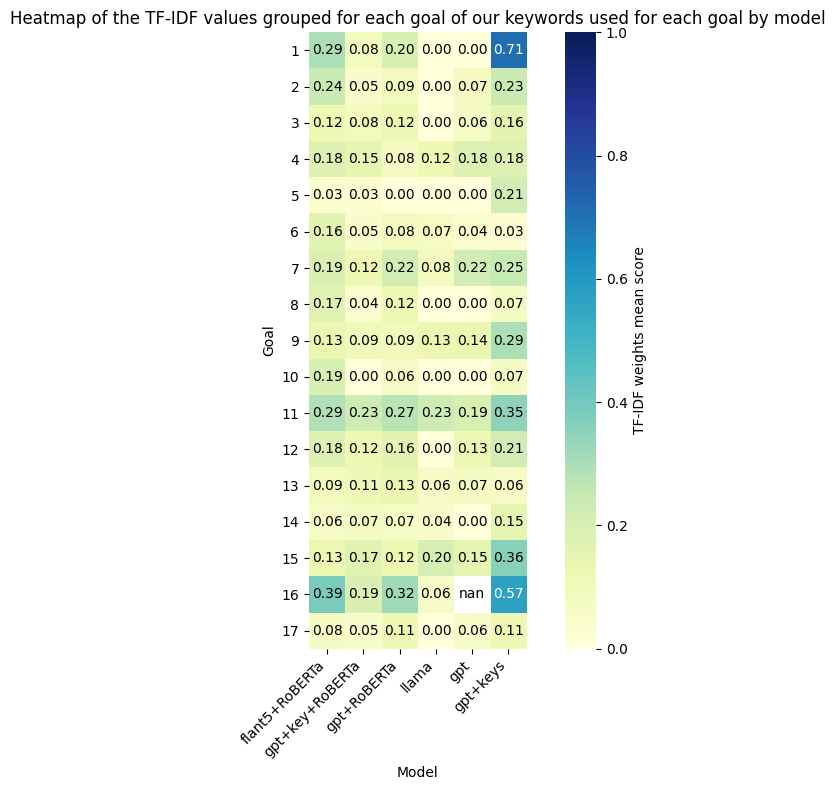

In [53]:
# ---------------------------------------------------------------------
# 7. Aggregate: average net_score per (goal, model); then normalize 0‑1
# ---------------------------------------------------------------------
agg = (all_data
       .groupby(["goal", "model"])["total_score"]
       .mean()
       .reset_index())

# 0–1 normalisation for the heat‑map
min_v, max_v = agg["total_score"].min(), agg["total_score"].max()
agg["norm_score"] = (agg["total_score"] - min_v) / (max_v - min_v + 1e-12)

# ---------------------------------------------------
# 8. Pivot so rows=goals, cols=models → heatmap data
# ---------------------------------------------------
model_order = ['flant5+RoBERTa', 'gpt+key+RoBERTa', 'gpt+RoBERTa', 'llama', 'gpt', 'gpt+keys']
heatmap_df = agg.pivot(index="goal", columns="model", values="total_score").sort_index()
heatmap_df = heatmap_df[[col for col in model_order if col in heatmap_df.columns]]
data = heatmap_df.values
threshold = (data.max() + data.min()) / 2.0

# ---------------------------------
# 9. Plotting the heatmap
# ---------------------------------
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(heatmap_df,cmap="YlGnBu", vmin=0, vmax=1)      # default colormap

# Tick labels -------------------------------------------------------------
ax.set_xticks(np.arange(len(heatmap_df.columns)))
ax.set_xticklabels(heatmap_df.columns, rotation=45, ha="right")
ax.set_yticks(np.arange(len(heatmap_df.index)))
ax.set_yticklabels(heatmap_df.index)

ax.set_xlabel("Model")
ax.set_ylabel("Goal")
ax.set_title("Heatmap of the TF-IDF values grouped for each goal of our keywords used for each goal by model")

for edge in ("top", "bottom", "left", "right"):
    ax.spines[edge].set_visible(False)       # hide axes frame

for i in range(data.shape[0]):          # rows  = goals
    for j in range(data.shape[1]):      # cols  = models
        val = data[i, j]
        text_color = "white" if val > 0.5 else "black"
        ax.text(j, i, f"{val:.2f}", ha="center", va="center", color=text_color)

# Color‑bar ---------------------------------------------------------------
cbar = fig.colorbar(im, ax=ax, label='TF-IDF weights mean score')  # Create colorbar
cbar.outline.set_visible(False) # Access outline via cbar object

plt.tight_layout()
plt.show()

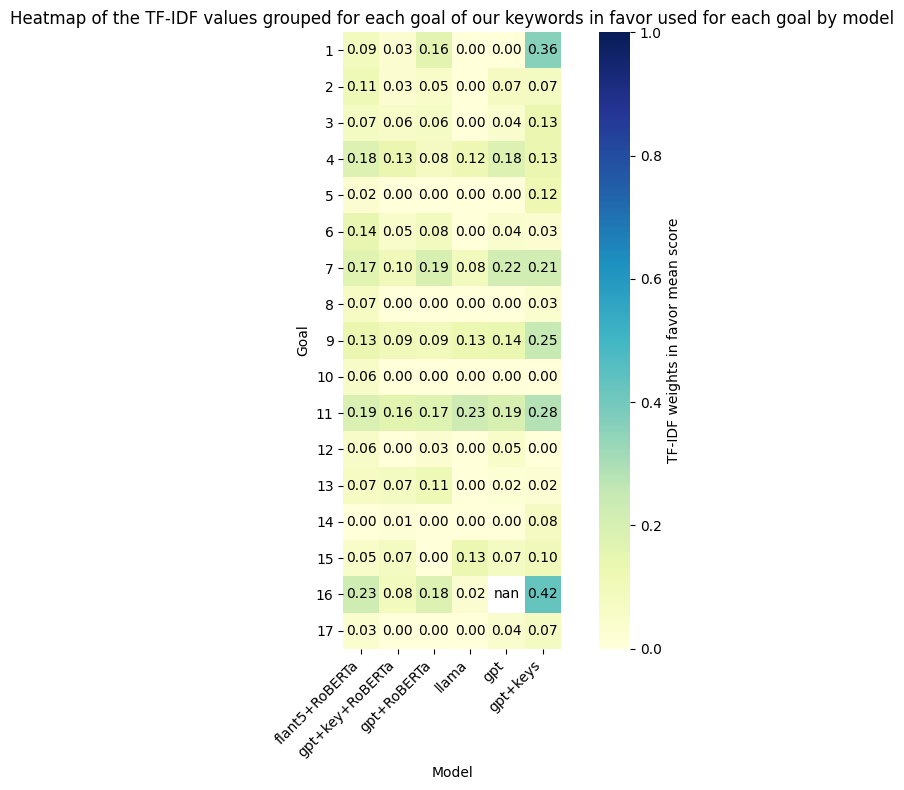

In [54]:
# ---------------------------------------------------------------------
# 7. Aggregate: average net_score per (goal, model); then normalize 0‑1
# ---------------------------------------------------------------------
agg = (all_data
       .groupby(["goal", "model"])["favor_score"]
       .mean()
       .reset_index())

# 0–1 normalisation for the heat‑map
min_v, max_v = agg["favor_score"].min(), agg["favor_score"].max()
agg["norm_score"] = (agg["favor_score"] - min_v) / (max_v - min_v + 1e-12)

# ---------------------------------------------------
# 8. Pivot so rows=goals, cols=models → heatmap data
# ---------------------------------------------------
heatmap_df = agg.pivot(index="goal", columns="model", values="favor_score").sort_index()
heatmap_df = heatmap_df[[col for col in model_order if col in heatmap_df.columns]]
data = heatmap_df.values

# ---------------------------------
# 9. Plotting the heatmap
# ---------------------------------
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(heatmap_df,cmap="YlGnBu", vmin=0, vmax=1)      # default colormap

# Tick labels -------------------------------------------------------------
ax.set_xticks(np.arange(len(heatmap_df.columns)))
ax.set_xticklabels(heatmap_df.columns, rotation=45, ha="right")
ax.set_yticks(np.arange(len(heatmap_df.index)))
ax.set_yticklabels(heatmap_df.index)

ax.set_xlabel("Model")
ax.set_ylabel("Goal")
ax.set_title("Heatmap of the TF-IDF values grouped for each goal of our keywords in favor used for each goal by model")

for edge in ("top", "bottom", "left", "right"):
    ax.spines[edge].set_visible(False)       # hide axes frame


for i in range(data.shape[0]):          # rows  = goals
    for j in range(data.shape[1]):      # cols  = models
        val = data[i, j]
        text_color = "white" if val > 0.5 else "black"
        ax.text(j, i, f"{val:.2f}", ha="center", va="center", color=text_color)

# Color‑bar ---------------------------------------------------------------
cbar = fig.colorbar(im, ax=ax, label='TF-IDF weights in favor mean score')  # Create colorbar
cbar.outline.set_visible(False) # Access outline via cbar object

plt.tight_layout()
plt.show()

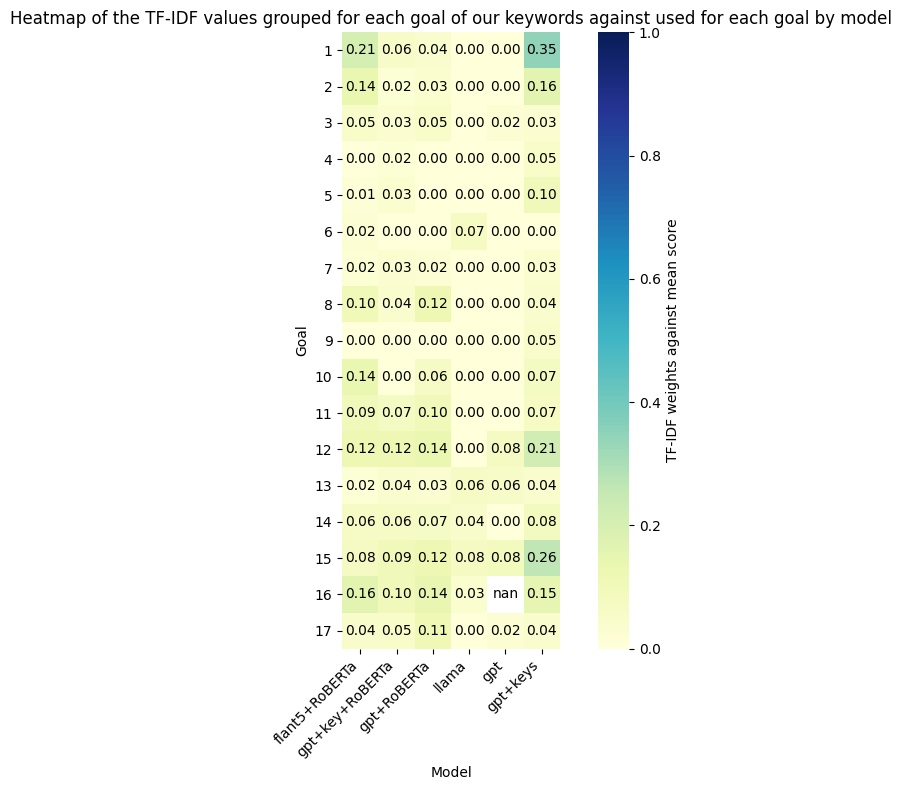

In [55]:
# ---------------------------------------------------------------------
# 7. Aggregate: average net_score per (goal, model); then normalize 0‑1
# ---------------------------------------------------------------------
agg = (all_data
       .groupby(["goal", "model"])["against_score"]
       .mean()
       .reset_index())

# 0–1 normalisation for the heat‑map
min_v, max_v = agg["against_score"].min(), agg["against_score"].max()
agg["norm_score"] = (agg["against_score"] - min_v) / (max_v - min_v + 1e-12)

# ---------------------------------------------------
# 8. Pivot so rows=goals, cols=models → heatmap data
# ---------------------------------------------------
heatmap_df = agg.pivot(index="goal", columns="model", values="against_score").sort_index()
heatmap_df = heatmap_df[[col for col in model_order if col in heatmap_df.columns]]
data = heatmap_df.values

# ---------------------------------
# 9. Plotting the heatmap
# ---------------------------------
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(heatmap_df,cmap="YlGnBu", vmin=0, vmax=1)

# Tick labels -------------------------------------------------------------
ax.set_xticks(np.arange(len(heatmap_df.columns)))
ax.set_xticklabels(heatmap_df.columns, rotation=45, ha="right")
ax.set_yticks(np.arange(len(heatmap_df.index)))
ax.set_yticklabels(heatmap_df.index)

ax.set_xlabel("Model")
ax.set_ylabel("Goal")
ax.set_title("Heatmap of the TF-IDF values grouped for each goal of our keywords against used for each goal by model")

for edge in ("top", "bottom", "left", "right"):
    ax.spines[edge].set_visible(False)       # hide axes frame

# Color‑bar ---------------------------------------------------------------
cbar = fig.colorbar(im, ax=ax, label='TF-IDF weights against mean score')  # Create colorbar
cbar.outline.set_visible(False) # Access outline via cbar object

for i in range(data.shape[0]):          # rows  = goals
    for j in range(data.shape[1]):      # cols  = models
        val = data[i, j]
        text_color = "white" if val > 0.5 else "black"
        ax.text(j, i, f"{val:.2f}", ha="center", va="center", color=text_color)

plt.tight_layout()
plt.show()